# Introduction  

Copulas (Copulae) are functions that combine the marginal distributions of several variables into a joint distribution that matches their correlation structure. They enable us to construct multivariate distributions from any univariate distributions, and to capture the dependence among them. Copulas have various forms and applications, such as Gaussian, Archimedean, and non-parametric copulas, which are used in finance, engineering, and machine learning, respectively.   
Copulas are useful tools to capture both linear and non-linear dependencies between two stocks because they can model the joint distribution of the stock returns without making any assumptions about their marginal distributions. This means that copulas can account for different behaviors and shapes of the stock returns, i.e. fat tails, skewness, multimodality, etc., which in terms, provides a great application for market-neutral strategies such as Pairs Trading.   

### A Brief Overview of Copulas  
The technical detail of copulas, although intuitively straightforward, is rather quite long and deserves an extensive introduction (which I highly recommend the following article: [Copulas: An Essential Guide & Applications in Time Series Forecasting](https://towardsdatascience.com/copulas-an-essential-guide-applications-in-time-series-forecasting-f5c93dcd6e99)).  
For those who are not familiar, this below will illustrate a short graphical guide to present the conceptual intuition of copulas.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15, 8)

In [2]:
# set global parameters
np.random.seed(seed=5)
sample_size = 5000
joint_plot_height = 7

Suppose we have 2 Normally distributed random variables
with a correlation of 0.8
presented as a bivariate normal distribution:

In [3]:
# Define the Bi-variate Normal parameters
mean = [0,0]
rho = 0.8
cov = [[1,rho],[rho,1]] # diagonal covariance, points lie on x or y-axis

# Draw samples from the Bi-variate Normal samples
multivariate_normal_sample = np.random.multivariate_normal(mean, cov, sample_size)
norm_1, norm_2 = multivariate_normal_sample.T
# and their Cumulative Distribution Functions (CDFs) 
multivariate_uniform_sample = stats.norm.cdf(multivariate_normal_sample, loc=mean)
unif_1, unif_2 = multivariate_uniform_sample.T # uniform samples

print("Correlation Matrix: \n", np.corrcoef(multivariate_uniform_sample, rowvar=False))

Correlation Matrix: 
 [[1.         0.79303006]
 [0.79303006 1.        ]]


The correlation is plotted as the following:


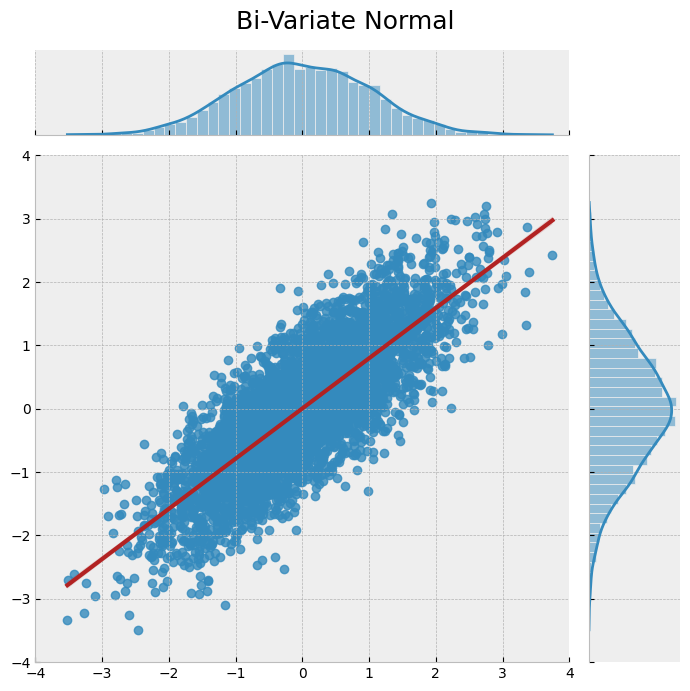

In [4]:
joint_grid = sns.jointplot(x=norm_1, y=norm_2, kind="reg", height=joint_plot_height, xlim=(-4, 4), ylim=(-4, 4),
                           joint_kws={"line_kws": {"color": "firebrick"}})

plt.suptitle("Bi-Variate Normal", fontsize=18)
plt.tight_layout()

This is how we all do using correlation!

BUT,  
 what if the data looks differently, what if the 2 variables are neither *Normal* nor *Linearly* correlated.  

#### Suppose a real world scenario where we need to measure the correlation between 2 quantities: the amounts of **time** and **money** spent on an online retailer.  
First, lets simulate our data using the [Inverse Transform Sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) method, by converting the two previous Uniform samples of the Normal CDFs computed above to the PDFs of the *Gamma* and *Beta* distributions respectively for *time* and *money*:

In [5]:
# generate time and money data as Gamma and Beta distributions respectively
# using the inverse sampling method (.ppf() functions)
# from the previous Normal CDFs
website_time = stats.gamma.ppf(unif_1, a=2, scale=5)
website_money = stats.beta.ppf(unif_2, a=0.5, b=0.5, loc=5, scale=100)

Time spent on website


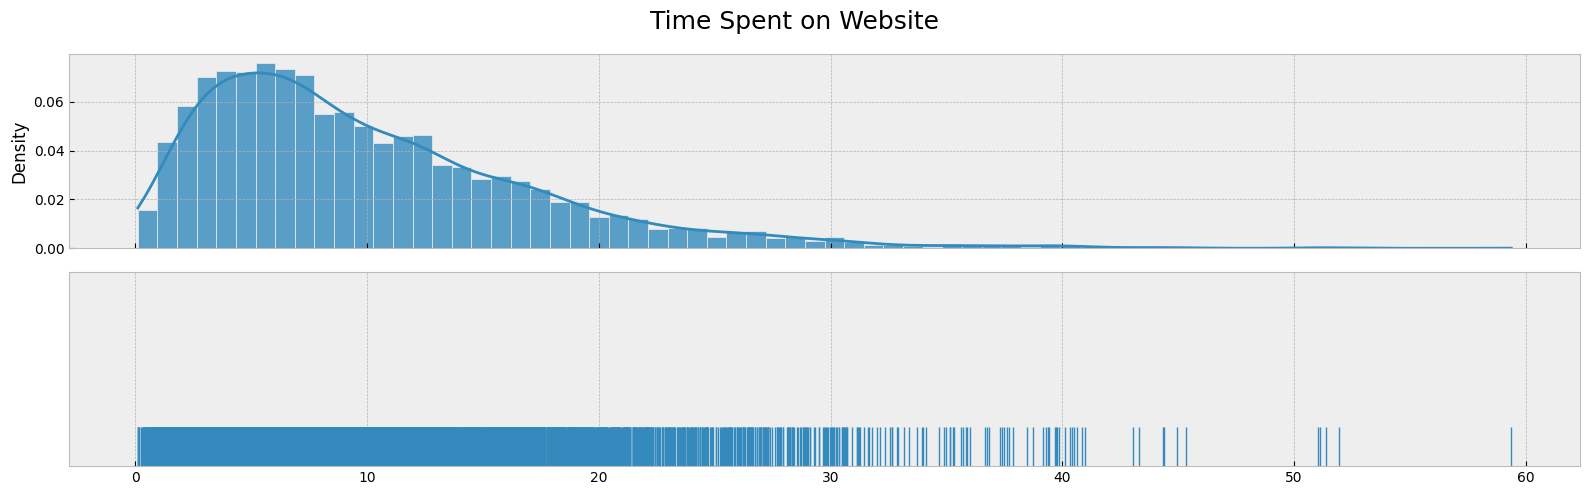

In [6]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 5), sharex=True)

ax = axes[0]
sns.histplot(x=website_time, kde=True, stat="density", bins=70, ax=ax, color=(0.20, 0.54, 0.74), alpha=0.8)

ax = axes[1]
sns.rugplot(x=website_time, ax=ax, height=0.2)
ax.set_yticks([])

plt.suptitle("Time Spent on Website", fontsize=18)
plt.tight_layout()

Dollars spent on website


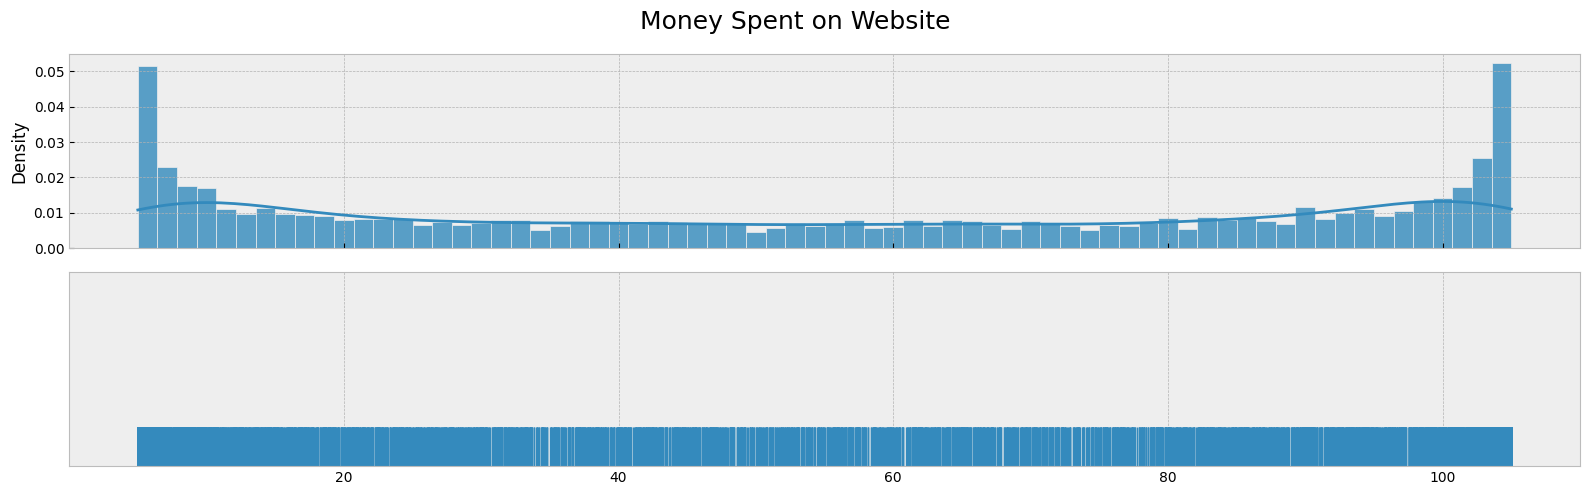

In [7]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 5), sharex=True)

ax = axes[0]
sns.histplot(x=website_money, kde=True, stat="density", bins=70, ax=ax, color=(0.20, 0.54, 0.74), alpha=0.8)

ax = axes[1]
sns.rugplot(x=website_money, ax=ax, height=0.2)
ax.set_yticks([])

plt.suptitle("Money Spent on Website", fontsize=18)
plt.tight_layout()

Correlation of time vs money spent on website 

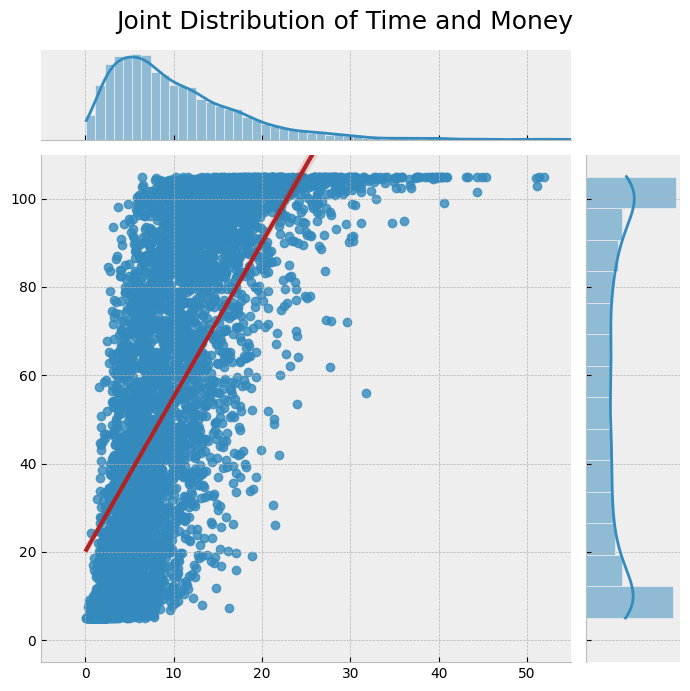

In [8]:
joint_grid = sns.jointplot(x=website_time, y=website_money, kind="reg", height=joint_plot_height, xlim=(-5, 55), ylim=(-5, 110),
                           joint_kws={"line_kws": {"color": "firebrick"}})

plt.suptitle("Joint Distribution of Time and Money", fontsize=18)
plt.tight_layout()

In [16]:
correlation_coefficient = np.corrcoef([website_time, website_money])[0, -1]
print(f"Correlation between time and money is: {correlation_coefficient:.4f}")

Correlation between time and money is: 0.7179


Something is different!  
Remember the original correlation (of the two Normal samples from which the new data was generated) was approx. **0.7930**?

##### Let's use the [*Probability Integral Transform*](https://en.wikipedia.org/wiki/Probability_integral_transform) to generate Uniform samples from the CDFs of the above Gamma and Beta distributions.

In [10]:
# Probability integral Transform to CDFs
website_time_cdf = stats.gamma.cdf(website_time, a=2, scale=5)
website_money_cdf = stats.beta.cdf(website_money, a=0.5, b=0.5, loc=5, scale=100)

Time spent CDF


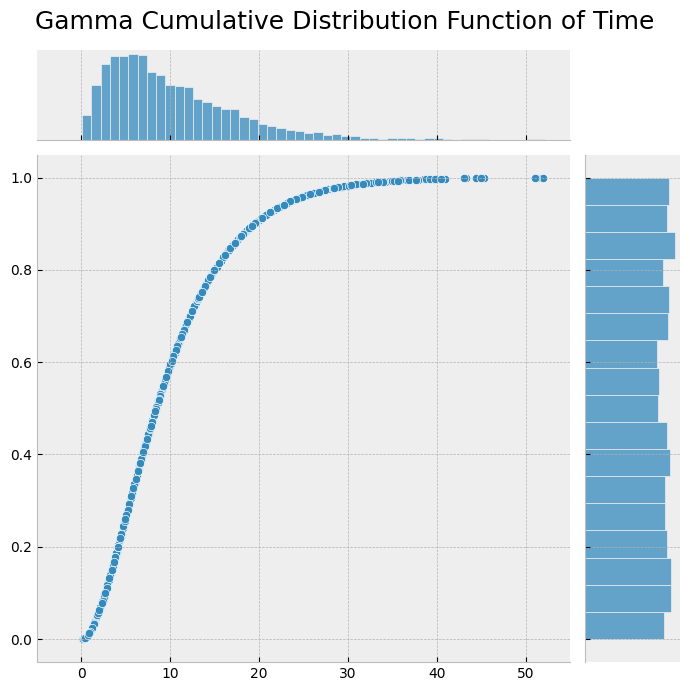

In [11]:
joint_grid = sns.jointplot(x=website_time, y=website_time_cdf, height=joint_plot_height, xlim=(-5, 55), ylim=(-0.05, 1.05))

plt.suptitle("Gamma Cumulative Distribution Function of Time", fontsize=18)
plt.tight_layout()

Money spent CDF

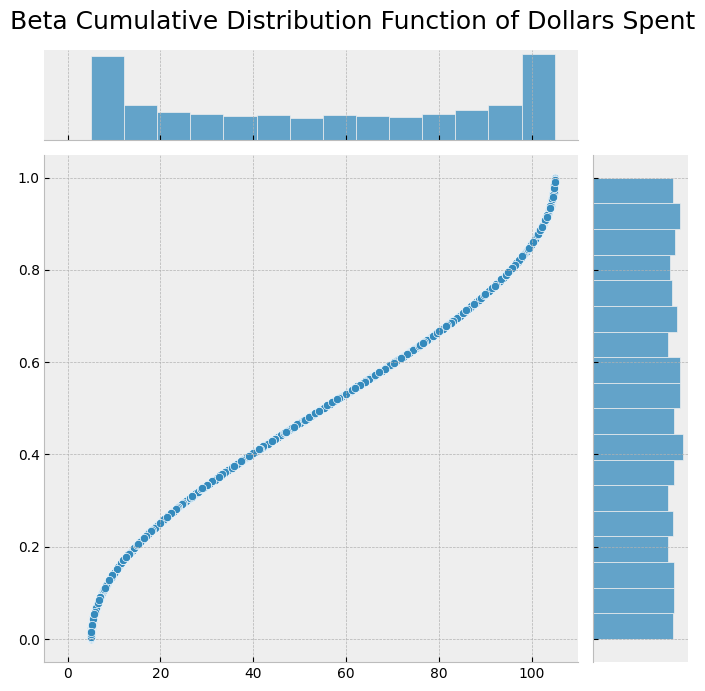

In [12]:
joint_grid = sns.jointplot(x=website_money, y=website_money_cdf, height=joint_plot_height, xlim=(-5, 110), ylim=(-0.05, 1.05))

plt.suptitle("Beta Cumulative Distribution Function of Dollars Spent", fontsize=18)
plt.tight_layout()

#### The correlation between the CDFs of Time vs Money

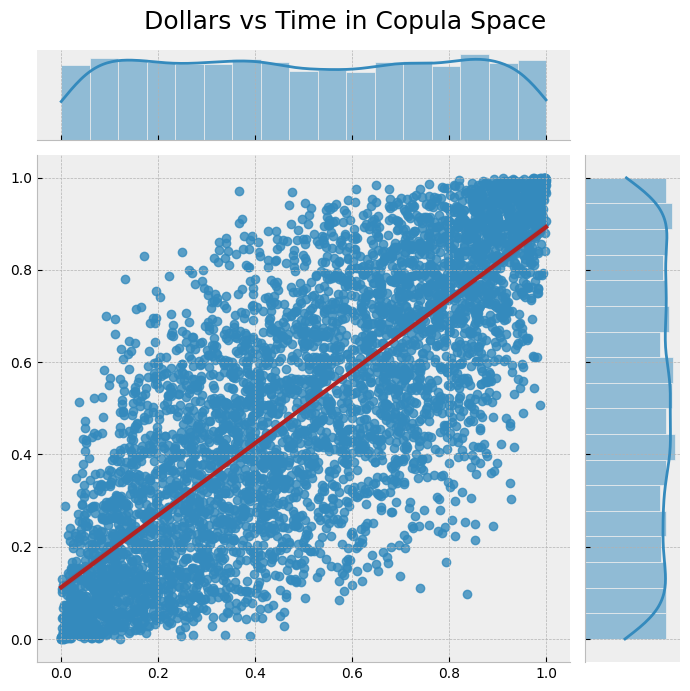

In [13]:
joint_grid = sns.jointplot(x=website_time_cdf, y=website_money_cdf, kind="reg", height=joint_plot_height, xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
                           joint_kws={"line_kws": {"color": "firebrick"}})

plt.suptitle("Dollars vs Time in Copula Space", fontsize=18)
plt.tight_layout()

In [15]:
correlation_coefficient = np.corrcoef([website_time_cdf, website_money_cdf])[0, -1]
print(f"Actual correlation between Time and Money is: {correlation_coefficient:.4f}")

Actual correlation between Time and Money is: 0.7930


Voila!

As you can see, we started with incorrect assumptions about our data, namely two variables are linearly correlated, and hence pertained a correlation metric that is not representative of the data.  
However, if we instead started by identifying the marginal distributions of our data (Gamma & Beta), then transforming them into Uniform distributions by converting the distribution samples to their respective CDFs (via Probability integral Transform) and subsequently, from measuring the linear relationship between the two Uniform distributions, we acquired more accurate information about the dependency between the variables.

*This is essentially what Copulas do, to measure the structural dependence between distributions of any two (or more) random variables.*

### Examples of Copulas

There are many types of Copulas, each uniquely captures a particular type of structural dependence between random variables. There are 2 common families of copulas: the *Elliptical* copulas (derived from elliptical distributions, which are characterized by a location vector, a scale matrix, and a radial part) which includes the Normal and T copulas, and the more flexible *Archimedean* copulas which are characterized by a single generator function.  
Some examples of Archimedean copulas are:  
- *Frank copula*: This copula can model symmetric dependence between random variables, meaning that the strength of dependence is the same in the upper and lower tails.  
- *Gumbel copula*: This copula can model asymmetric dependence between random variables, meaning that the strength of dependence is stronger in the upper tail than in the lower tail.  
- *Clayton copula*: This copula can also model asymmetric dependence between random variables, but in the opposite way of the Gumbel copula, meaning that the strength of dependence is stronger in the lower tail than in the upper tail.

![alt text](examples.png "Common Types of Copulas")

# Pairs Trading using Copulas  


### Prepare Data
Binance's *Spot Hourly-intraday* data from March 2021 to Semptember 2022 will be used.  
**NOTE**:  
The reason for choosing this period is due to the maximum data history available and a corruption issue (empty data betwwen the end of "2022-09" and the start of "2023-05") from Binance Kline as demonstrated in my earlier work - *Copulas for Pairs Trading*.  

In [2]:
prices = pd.read_csv(r"\Pairs-Trading-Statistical-Arbitrage\Hourly_Crypto_data.csv", parse_dates=[0], index_col=[0], engine='c').loc[:"2022-09-15"]
print("Number of Cryptocurrency symbols: ", len(prices.columns))
prices.tail()

Number of Cryptocurrency symbols:  130


,ANTUSDT,ETHUSDT,XEMUSDT,KAVAUSDT,XVSUSDT,CHRUSDT,BTCUSDT,ADAUSDT,BELUSDT,CHZUSDT,...,XTZUSDT,SNXUSDT,VETUSDT,NEOUSDT,FILUSDT,BANDUSDT,FTMUSDT,LTCUSDT,IOTXUSDT,USDCUSDT
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-09-15 19:00:00,1.686,1497.63,0.0417,1.554,4.50,0.1578,19782.36,0.4679,0.599,0.1928,...,1.542,2.623,0.02341,9.11,5.78,1.208,0.2433,56.89,0.02734,1.0000
2022-09-15 20:00:00,1.686,1503.99,0.0417,1.557,4.50,0.1578,19850.32,0.4697,0.601,0.1968,...,1.550,2.629,0.02351,9.20,5.80,1.212,0.2438,57.10,0.02744,1.0000
2022-09-15 21:00:00,1.679,1490.41,0.0417,1.548,4.49,0.1568,19828.85,0.4666,0.598,0.1926,...,1.545,2.616,0.02340,9.16,5.77,1.209,0.2429,56.74,0.02732,1.0000
2022-09-15 22:00:00,1.666,1475.04,0.0411,1.535,4.45,0.1552,19729.11,0.4645,0.592,0.1907,...,1.528,2.592,0.02319,9.09,5.69,1.204,0.2412,56.33,0.02705,1.0001
2022-09-15 23:00:00,1.659,1472.75,0.0410,1.532,4.47,0.1554,19701.88,0.4662,0.593,0.1911,...,1.520,2.583,0.02321,9.13,5.72,1.205,0.2406,56.34,0.02696,1.0001


The strategy algorithm will be demonstrated in ordered steps in this section:

### 1. Pair Selection
The first step is identifying potential pairs for trading.  
Pairs in top *90th percentile* of the highest [Kendall’s rank correlation coefficient](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient) (Kendall’s tau) between log-returns will be selected.  



In [3]:
def calc_rank_correlation(log_returns: pd.DataFrame) -> pd.Series:
    """
    Calculate the Kendall’s rank correlation coefficient statistic for pairwise comparison of columns in a DataFrame.
    
    Parameters:
        log_returns (pd.DataFrame): A DataFrame containing log returns of assets.
        
    Returns:
        pd.Series: A Series containing the Kendall’s rank correlation coefficient statistic for pairwise comparison of columns.
    """
    tau_ser = pd.Series(name="tau")
    for s1 in log_returns.columns:
        for s2 in log_returns.columns:
            if (s1 != s2) and (f"{s2}-{s1}" not in tau_ser.index):
                try:
                    tau_ser.loc[f"{s1}-{s2}"] = stats.kendalltau(
                        log_returns[s1].values, log_returns[s2].values
                    )[0]
                except:
                    continue
    return tau_ser


def parse_pair(pair):
    """
    Parse a pair string into two separate strings.

    Parameters:
        pair (str): A string representing a pair of values separated by a hyphen.

    Returns:
        tuple: A tuple containing two strings, the first string before the hyphen and the second string after the hyphen.
    """
    s1 = pair[: pair.find("-")]
    s2 = pair[pair.find("-") + 1 :]
    return s1, s2


def preprocess_data(data: pd.DataFrame):
    """Clean and log-transform the price dataframe."""  
    # Impute missing or infinite values
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Interpolate missing values
    data.interpolate(source='spline', order=5, limit_direction='both', inplace=True)
    # drop nan values
    data.dropna(inplace=True)
    # Compute Log-Returns
    try:
        df = np.log(data)
        log_returns = df.diff().dropna()
        return log_returns
    
    except ValueError as e:
        print(f"Log-transforming data FAILED!!!\
                \n{type(e).__name__}: {str(e)}\n")
        return     

In [4]:
# create train dataset of 1 month
train_data = prices.iloc[:720]

log_returns = preprocess_data(train_data)
kendall_T = calc_rank_correlation(train_data)
top_kendall_T = kendall_T[kendall_T > kendall_T.quantile(0.9)]

# Select pairs
selected_assets = []
selected_pairs = []
for pair in reversed(top_kendall_T.index):
    s1, s2 = parse_pair(pair)
    if (s1 not in selected_assets) and (s2 not in selected_assets):
        selected_assets.append(s1)
        selected_assets.append(s2)
        selected_pairs.append(pair)

In [5]:
print(selected_pairs)

['FILUSDT-IOTXUSDT', 'VETUSDT-NEOUSDT', 'XTZUSDT-LTCUSDT', 'COCOSUSDT-BANDUSDT', 'OGNUSDT-HOTUSDT', 'SFPUSDT-TLMUSDT', 'RVNUSDT-EGLDUSDT', 'BATUSDT-CTKUSDT', 'TRXUSDT-ALGOUSDT', 'FETUSDT-DENTUSDT', 'OCEANUSDT-FTMUSDT', 'STORJUSDT-MTLUSDT', 'UNFIUSDT-ENJUSDT', 'IOSTUSDT-ZRXUSDT', 'CFXUSDT-INJUSDT', 'ARPAUSDT-SXPUSDT', 'BNTUSDT-TRBUSDT', 'AXSUSDT-RSRUSDT', 'MANAUSDT-OXTUSDT', 'STPTUSDT-SANDUSDT', 'KEYUSDT-LITUSDT', 'BALUSDT-BNBUSDT', 'DGBUSDT-STXUSDT', 'MKRUSDT-TWTUSDT', 'ONTUSDT-STRAXUSDT', 'ROSEUSDT-CAKEUSDT', 'OMGUSDT-LINKUSDT', 'RIFUSDT-GRTUSDT', 'ALICEUSDT-LINAUSDT', 'RENUSDT-THETAUSDT', 'BCHUSDT-ZECUSDT', 'ZILUSDT-1INCHUSDT', 'KNCUSDT-FLMUSDT', 'ANKRUSDT-STMXUSDT', 'ICXUSDT-IOTAUSDT', 'DUSKUSDT-AUDIOUSDT', 'CHZUSDT-SKLUSDT', 'BTCUSDT-MDTUSDT', 'CHRUSDT-NKNUSDT', 'KAVAUSDT-TOMOUSDT', 'ANTUSDT-XEMUSDT']


### 2. Fit Marginals  
Find the best fitted marginal distributions for individual currencies within each pair.
The five following four parametric distributions will be used: Normal, Laplace, Student’s t, Logistic and Extreme.  
The best fitted distributions will be chosen based on Bayesian Information Criterion (BIC), and then those that pass the Kolmogorov-Smirnov goodness-of-fit test will be carried on as our selected distributions. 

In [4]:
def fit_marginals(
    log_returns: pd.DataFrame, selected_assets: list[str]
) -> dict:
    """
    Fits marginal distributions to the given log returns data for selected assets.

    Parameters:
    - log_returns: A pandas DataFrame containing the log returns data.
    - selected_assets: A list of strings representing the selected assets.

    Returns:
    - fitted_marginals: A dictionary mapping each stock to the best fitted marginal distribution.
    """
    fitted_marginals = {}
    for stock in selected_assets:
        
        data = log_returns[stock]
        best_pval = 0.0

        for dist in [
            stats.norm,
            stats.laplace,
            stats.t,
            stats.genhyperbolic,
            stats.genextreme,
        ]:
            try:
                params = dist.fit(data)
                dist_fit = dist(*params)
                ks_pval = stats.kstest(data, dist_fit.cdf, N=len(data))[1]
                if ks_pval > best_pval:
                    best_dist = dist_fit
                    best_pval = ks_pval
            except:
                continue
            
        fitted_marginals[stock] = best_dist

    return fitted_marginals

In [19]:
fitted_marginals = fit_marginals(log_returns, selected_assets)
# First 10 fitted marginals
for ticker, dist in list(fitted_marginals.items())[:10]:
    print(f"Cryptocurrency: '{ticker}', Marginal Distribution: {dist.dist.name.upper()}.")

Cryptocurrency: 'FILUSDT', Marginal Distribution: T.
Cryptocurrency: 'IOTXUSDT', Marginal Distribution: GENHYPERBOLIC.
Cryptocurrency: 'VETUSDT', Marginal Distribution: T.
Cryptocurrency: 'NEOUSDT', Marginal Distribution: GENHYPERBOLIC.
Cryptocurrency: 'XTZUSDT', Marginal Distribution: GENHYPERBOLIC.
Cryptocurrency: 'LTCUSDT', Marginal Distribution: GENHYPERBOLIC.
Cryptocurrency: 'COCOSUSDT', Marginal Distribution: GENHYPERBOLIC.
Cryptocurrency: 'BANDUSDT', Marginal Distribution: GENHYPERBOLIC.
Cryptocurrency: 'OGNUSDT', Marginal Distribution: T.
Cryptocurrency: 'HOTUSDT', Marginal Distribution: GENHYPERBOLIC.


### 3. Fit Copulas  
First, individual assets' log returns are converted to their Uniform samples (CDFs) via applying the Probability Integral Transform to their best fitted marginal distributions earlier.  
Then fitting each pair's log return CDFs to seven Copula types: Gaussian, N13, N14, Clayton, Gumbel, Frank and Joe.
Copulas with the either smallest Akaike Information Criterion (AIC) or the Bayesian Information Criterion (BIC) will be selected for the two-dimensional Kolmogorov-Smirnov test.  
The two-dimensional Kolmogorov-Smirnov test compares the join-CDFs between 2 pairs of marginal distributions and the Null Hypothesis is that they are identical (the github repo of its Python implementation is [here](https://github.com/syrte/ndtest/blob/master/ndtest.py)).  
The top **10** Copulas which pass the 2d-KS test with the highest P-values will beour selected Copulas for trading.  
  
  
(OR The top **10** Copulas which pass the 2d-KS test with the highest P-values while also have the lowest AIC and BIC scores will be our selected Copulas for trading.
)

In [5]:
import copulas # Thanks to courtesy of Alexander Pavlov at https://github.com/financialnoob
import ndtest

def fit_copulas(
    log_returns: pd.DataFrame, fitted_marginals: dict, selected_pairs: list[tuple[str]]
) -> tuple[pd.DataFrame, dict]:
    """
    Fits copulas to log returns data.

    Args:
        log_returns (pd.DataFrame): A DataFrame containing log returns data.
        fitted_marginals (dict): A dictionary of fitted marginal distributions.
        selected_pairs (list): A list of selected pairs of assets.

    Returns:
        Tuple[pd.DataFrame, dict]: A tuple containing two objects:
            - copulas_df: A DataFrame with fit statistics for each pair of assets.
            - fitted_copulas: A dictionary of fitted copula models for each pair of assets.
    """
    copulas_df = pd.DataFrame(index=selected_pairs, columns=["KS_pvalue"])
    fitted_copulas = {}

    for pair in selected_pairs:
        s1, s2 = parse_pair(pair)

        dist_s1 = fitted_marginals[s1]
        dist_s2 = fitted_marginals[s2]

        # apply probability integral transform
        u = dist_s1.cdf(log_returns[s1])
        v = dist_s2.cdf(log_returns[s2])

        best_aic = np.inf
        best_bic = np.inf
        best_copula = None

        for copula in [
            copulas.GaussianCopula(),
            copulas.N13Copula(),
            copulas.N14Copula(),
            copulas.ClaytonCopula(),
            copulas.GumbelCopula(),
            copulas.FrankCopula(),
            copulas.JoeCopula(),
        ]:
            try:
                copula.fit(u, v)
                L = copula.log_likelihood(u, v)
                aic = 2 * copula.num_params - 2 * L
                bic = copula.num_params * np.log(len(u)) - 2 * L
                if aic < best_aic or bic < best_bic:
                    best_aic = aic
                    best_bic = bic
                    best_copula = copula
                    # calculate KS-pvalue
                    smp = best_copula.sample(size=len(u))  # generate sample from fit copula
                    s_u = smp[:, 0]
                    s_v = smp[:, 1]
                    ks_pval = ndtest.ks2d2s(u, v, s_u, s_v)
                    if ks_pval > 0.2: # 20% threshold indicates significant as the authors recommended.
                        copulas_df.loc[pair, "KS_pvalue"] = ks_pval
                        fitted_copulas[pair] = {"s1": dist_s1, "s2": dist_s2, "copula": best_copula}
            except:
                continue

    return copulas_df, fitted_copulas

In [9]:
copulas_df, fitted_copulas = fit_copulas(log_returns, fitted_marginals, selected_pairs)
if copulas_df.empty:
    print("No Copulas satisfied the 2D-KS test.")
# sort the copulas_df by the lowest aic, bic and the highest KS_pvalue
# sorted_copulas_df = copulas_df.sort_values(
#     by=["KS_pvalue", "bic", "aic"], ascending=[False, True, True]
# )
# sort the copulas_df by the highest KS_pvalue
sorted_copulas_df = copulas_df.sort_values(
    by=["KS_pvalue"], ascending=[False]
)

top_copulas_df = sorted_copulas_df.iloc[:10]

top_copulas_df

,KS_pvalue
XTZUSDT-LTCUSDT,0.763222
ANKRUSDT-STMXUSDT,0.652747
FETUSDT-DENTUSDT,0.640863
MANAUSDT-OXTUSDT,0.618794
KEYUSDT-LITUSDT,0.577998
DGBUSDT-STXUSDT,0.566053
BTCUSDT-MDTUSDT,0.533873
RENUSDT-THETAUSDT,0.513687
STPTUSDT-SANDUSDT,0.506899
KNCUSDT-FLMUSDT,0.467183


Now that we are familiar with the trading algorithm's processes, let's neatly combine them into a single function


In [6]:

def formation(data: pd.DataFrame, use_num=False, num_pairs=10, top_pct: int = 0.9) -> dict[str, dict]:
    """
    Generate a formation based on the given data.

    Parameters:
    - data: A pandas DataFrame containing the input data.
    - top_pct: An integer representing the top percentile of tau values
    and the best fitted marginals and corresponding copulas.

    Returns:
    - result_dict: A dictionary of the selected pairs of assets
    and the best fitted marginals and corresponding copulas.
    """
    log_returns = preprocess_data(data)
    hoeffdingD_ser = calc_rank_correlation(log_returns)
    top_hoeffdingD_ser = hoeffdingD_ser[hoeffdingD_ser > hoeffdingD_ser.quantile(top_pct)]

    selected_assets = []
    selected_pairs = []
    for pair in top_hoeffdingD_ser.index:
        s1, s2 = parse_pair(pair)
        if (s1 not in selected_assets) and (s2 not in selected_assets):
            selected_assets.append(s1)
            selected_assets.append(s2)
            selected_pairs.append(pair)

    fitted_marginals = fit_marginals(log_returns, selected_assets)
    copulas_df, fitted_copulas = fit_copulas(log_returns, fitted_marginals, selected_pairs)
    # if all failed 2d-KS-test's criteria, return empty dict
    if copulas_df.empty:
        return {}
    # sort the copulas_df by the highest KS_pvalue
    sorted_copulas_df = copulas_df.sort_values(
        by=["KS_pvalue"], ascending=[False]
    )
    if use_num:
        top_copulas_df = sorted_copulas_df.iloc[:num_pairs]
    else: # get the top percentile
        p90 = int(len(sorted_copulas_df) * top_pct)
        top_copulas_df = sorted_copulas_df.iloc[:p90]
    # match the dictionaries in the dictionary fitted_copulas
    # with the top 90 percentile in top_copulas_df
    result_dict = {}
    for pair in top_copulas_df.index:
        if pair in fitted_copulas.keys():
            result_dict[pair] = fitted_copulas[pair]

    return result_dict


# Backtest
Trade decisions are made based on the conditional probabilities of each cryptocurrency pairs' log-returns. By defining Upper and Lower thresholds ($b_{up}$ & $b_{lo}$), we can determine the current return of one stock is too high, given the second stock's current return. This is demonstrated as the following:
- **Opening** rules:  
-- IF $P(U_1\le u_1 | U_2 = u_2) \le b_{lo}$ AND $P(U_2\le u_2 | U_1 = u_1) \ge b_{up}$,  
 then stock 1 is undervalued, and stock 2 is overvalued. Hence we long the spread. (1 in position)  
-- IF $P(U_2\le u_2 | U_1 = u_1) \le b_{lo}$ AND $P(U_1\le u_1 | U_2 = u_2) \ge b_{up}$,    
 then stock 2 is undervalued, and stock 1 is overvalued. Hence we short the spread. (-1 in position)
- **Exit** rule:  
If EITHER conditional probabilities cross the boundary of **0.3** (Long) or **0.7** (Short), then we exit the position, as we consider the position no longer valid. (0 in position). 

### Methodology: 
Lower threshold: $b_{lo}$ = **0.01**  
Upper threshold: $b_{up}$ = **0.99**  
Training period length: **1 month**.  
Trading period length: **1 week**.  
Leverage ratio: **1:20**.  
Transaction & commission fees: **0.25% per position**. 

In [7]:
train_window = 720 # 1 month
trade_window = 72 # 3 days
algo_returns = {}
top_copulas_dfs = []
for i in range(train_window, len(prices)-trade_window, trade_window):
    print("\n##################################################################################\n")
    print("Train period:", prices.index[i-train_window], "to", prices.index[i])
    print("Test period:", prices.index[i], "to", prices.index[i+trade_window+1])
    
    train = prices.iloc[i-train_window:i]
    returns_form = preprocess_data(train)
    test = prices.iloc[i:i+trade_window+1]
    returns_trade = preprocess_data(test)
    # Get fitted copulas
    results = formation(train)

    selected_pairs = list(results.keys())
    print(f"Selected pairs: {selected_pairs}\n")
    cl = 0.99 # confidence level
    fee = 0.0025 # trading fee

    for pair in selected_pairs:
        s1,s2 = parse_pair(pair)
                
        dist_s1 = results[pair]['s1']
        dist_s2 = results[pair]['s2']
        best_copula = results[pair]['copula']
        print(f"Pair: {pair}, Fitted copula: {best_copula.name}\n")   
        # calculate conditional probabilities
        prob_s1 = []
        prob_s2 = []

        for u,v in zip(dist_s1.cdf(returns_trade[s1]), dist_s2.cdf(returns_trade[s2])):
            prob_s1.append(best_copula.cdf_u_given_v(u,v))
            prob_s2.append(best_copula.cdf_v_given_u(u,v))
            
        probs_trade = pd.DataFrame(np.vstack([prob_s1, prob_s2]).T, index=returns_trade.index, columns=[s1, s2])

        # calculate positions
        positions = pd.DataFrame(index=probs_trade.index, columns=probs_trade.columns)
        long = False
        short = False

        for t in positions.index:    
            # if long position is open
            if long:
                if (probs_trade.loc[t][s1] >= 0.3) or (probs_trade.loc[t][s2] <= 0.7):
                    positions.loc[t] = [0-fee, 0-fee] # Add fee to close positions
                    long = False
                else:
                    positions.loc[t] = [1, -1]

            # if short position is open
            elif short:
                if (probs_trade.loc[t][s1] <= 0.7) or (probs_trade.loc[t][s2] >= 0.3):
                    positions.loc[t] = [0-fee, 0-fee]
                    short = False
                else:
                    positions.loc[t] = [-1, 1]

            # if no positions are open
            else:
                if (probs_trade.loc[t][s1] <= (1-cl)) and (probs_trade.loc[t][s2] >= cl):
                    # open long position
                    positions.loc[t] = [1-fee, -1-fee] # Add fee to open positions
                    long = True
                elif (probs_trade.loc[t][s1] >= cl) and (probs_trade.loc[t][s2] <= (1-cl)):
                    # open short positions
                    positions.loc[t] = [-1-fee, 1-fee]
                    short = True
                else:
                    positions.loc[t] = [0, 0]
            
        # calculate returns
        algo_ret = (returns_trade * positions.shift()).sum(axis=1)
        # append algo_ret to algo_returns
        if pair not in algo_returns.keys():
            algo_returns[pair] = []
        algo_returns[pair].append(algo_ret)


##################################################################################

Train period: 2021-04-30 12:00:00 to 2021-05-30 12:00:00
Test period: 2021-05-30 12:00:00 to 2021-06-02 13:00:00
Selected pairs: ['ZRXUSDT-ALGOUSDT', 'GRTUSDT-BNBUSDT', 'ATOMUSDT-LINKUSDT', 'XEMUSDT-CHZUSDT', 'YFIUSDT-BANDUSDT', 'DASHUSDT-BCHUSDT', 'OMGUSDT-BATUSDT', 'AUDIOUSDT-BNTUSDT', 'IOTAUSDT-LITUSDT', 'CRVUSDT-SUSHIUSDT', 'ALPHAUSDT-BALUSDT', 'NEOUSDT-LTCUSDT', 'XLMUSDT-TRXUSDT', 'MKRUSDT-AAVEUSDT', 'ICXUSDT-ONTUSDT', 'NEARUSDT-RSRUSDT', 'ADAUSDT-ZILUSDT', 'COMPUSDT-UNIUSDT', 'ARPAUSDT-OCEANUSDT', '1INCHUSDT-CTKUSDT', 'DUSKUSDT-CAKEUSDT', 'XRPUSDT-DOTUSDT', 'DENTUSDT-SFPUSDT', 'MANAUSDT-SXPUSDT', 'KAVAUSDT-KNCUSDT', 'ETHUSDT-BTCUSDT', 'EOSUSDT-XTZUSDT', 'COTIUSDT-ENJUSDT', 'TOMOUSDT-RVNUSDT']

Pair: ZRXUSDT-ALGOUSDT, Fitted copula: N14

Pair: GRTUSDT-BNBUSDT, Fitted copula: N13

Pair: ATOMUSDT-LINKUSDT, Fitted copula: N14

Pair: XEMUSDT-CHZUSDT, Fitted copula: N13

Pair: YFIUSDT-BANDUSDT, Fitted 

### Performance Summary

The Copulas strategy under 20x leverage significantly out-performed in all metrics when compared to the Bitcoin, particularly in lowing the over-all market risk which is generally high with cryptocurrencies. During the trading period from March, 2021 to September, 2022, Bitcoin's ROI was **-50.02%** while the MI strategy was **15.28%**. Max Drawdowns of Bitcoin and the Copulas strategy was respectively **-77.20%** versus **-1.21%** with the respective maximum negative PnL duration of BTC was more than **6 times** of the Copulas strategy's.

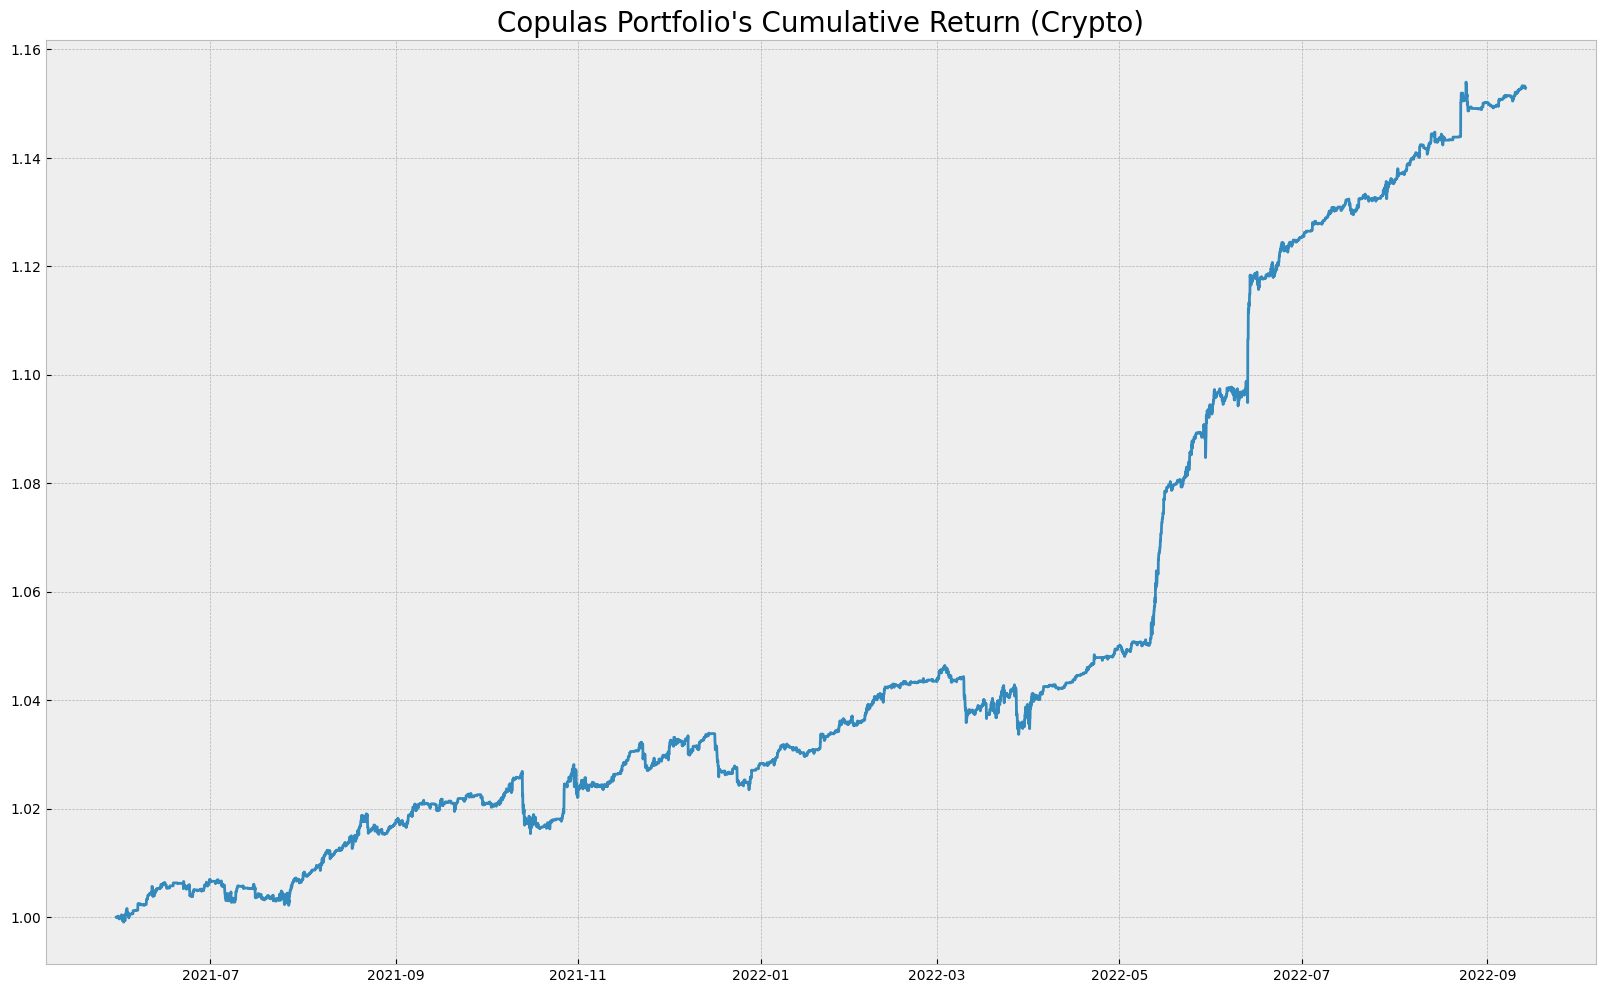

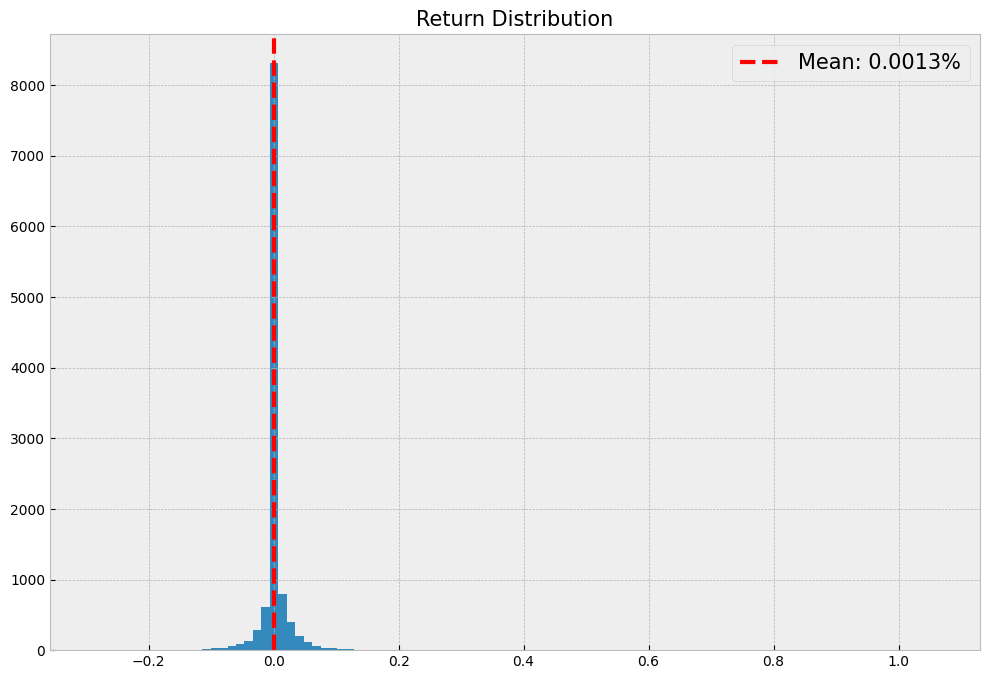

In [9]:
for pair in algo_returns.keys():
    algo_returns[pair] = pd.concat(algo_returns[pair]).convert_dtypes(infer_objects=True)
    algo_returns[pair].index = pd.to_datetime(algo_returns[pair].index)
    
returns = pd.DataFrame.from_dict(algo_returns).convert_dtypes(infer_objects=True)
returns.fillna(0, inplace=True)
returns = np.exp(returns) - 1 # convert log-returns to simple returns
total_ret = (returns * 20).sum(axis=1) / len(returns.columns) # Add 20x leverage
total_ret = total_ret.convert_dtypes(infer_objects=True)
# Calculate cumulative returns
cum_ret = np.nancumprod(total_ret + 1 )
# plot the total equity curve
plt.figure(figsize=(20, 12))
plt.title(f"Copulas Portfolio's Cumulative Return (Crypto)", fontsize=20)
plt.plot(total_ret.index, cum_ret)
plt.show()
# plot the histogram of portfolio's returns
plt.figure(figsize=(12, 8))
plt.hist(total_ret*100, bins=100)
plt.axvline(total_ret.mean()*100, ls='--', color='r', linewidth=3, label="Mean")
plt.title(f"Return Distribution", fontsize=15)
plt.legend([f"Mean: {round(total_ret.mean()*100, 4)}%"], fontsize=15)
plt.show()

**Compare with BTC performance**  

In [12]:
# BTC cumulative return
start = prices.index[0]
end = prices.index[-1]
btc_prices = get_all_binance('BTCUSDT', '1h').loc[start:end]
btc_return = btc_prices['close'].astype("float").pct_change()
cumret_baseline = np.nancumprod(btc_return + 1)

In [15]:
metrics_df = pd.DataFrame(index=['Total return', 'APR', 'Sharpe ratio', 'Max Drawdown', 'Max Drawdown Duration'], 
             columns=['BTC', 'Copulas Portfolio'])
metrics_df['BTC'] = calculate_metrics(cumret_baseline)
metrics_df['Copulas Portfolio'] = calculate_metrics(cum_ret)
metrics_df

,BTC,Copulas Portfolio
Total return,-0.500189,0.152823
APR,-0.015055,0.003175
Sharpe ratio,-0.065028,0.738190
Max Drawdown,-0.740521,-0.012155
Max Drawdown Duration,7369.000000,1170.000000
